# Build a Mamdani inference system

This tutorial gives a general overiew of FuzzyLogic.jl basic functionalities by showing how
to implement and use a type-1 Mamdani inference system.

DOWNLOAD_NOTE

## Setup

To follow the tutorial, you should have [installed Julia](https://julialang.org/downloads/).

Next, you can install `FuzzyLogic.jl` with

```julia
using Pkg; Pkg.add("FuzzyLogic")
```

## Building the inference system

First, we need to load the library.

In [1]:
using FuzzyLogic

The Mamdani inference system can be constructed with the `@mamfis` macro.
We will first give a full example and then explain every step.

In [2]:
fis = @mamfis function tipper(service, food)::tip
    service := begin
        domain = 0:10
        poor = GaussianMF(0.0, 1.5)
        good = GaussianMF(5.0, 1.5)
        excellent = GaussianMF(10.0, 1.5)
    end

    food := begin
        domain = 0:10
        rancid = TrapezoidalMF(-2, 0, 1, 3)
        delicious = TrapezoidalMF(7, 9, 10, 12)
    end

    tip := begin
        domain = 0:30
        cheap = TriangularMF(0, 5, 10)
        average = TriangularMF(10, 15, 20)
        generous = TriangularMF(20, 25, 30)
    end

    and = ProdAnd
    or = ProbSumOr
    implication = ProdImplication

    service == poor || food == rancid --> tip == cheap
    service == good --> tip == average
    service == excellent || food == delicious --> tip == generous

    aggregator = ProbSumAggregator
    defuzzifier = CentroidDefuzzifier
end

tipper

Inputs:
-------
service ∈ [0, 10] with membership functions:
    poor = GaussianMF{Float64}(0.0, 1.5)
    good = GaussianMF{Float64}(5.0, 1.5)
    excellent = GaussianMF{Float64}(10.0, 1.5)

food ∈ [0, 10] with membership functions:
    rancid = TrapezoidalMF{Int64}(-2, 0, 1, 3)
    delicious = TrapezoidalMF{Int64}(7, 9, 10, 12)


Outputs:
--------
tip ∈ [0, 30] with membership functions:
    cheap = TriangularMF{Int64}(0, 5, 10)
    average = TriangularMF{Int64}(10, 15, 20)
    generous = TriangularMF{Int64}(20, 25, 30)


Inference rules:
----------------
(service is poor ∨ food is rancid) --> tip is cheap
service is good --> tip is average
(service is excellent ∨ food is delicious) --> tip is generous


Settings:
---------
- ProdAnd()
- ProbSumOr()
- ProdImplication()
- ProbSumAggregator()
- CentroidDefuzzifier(100)


As you can see, defining a fuzzy inference system with `@mamfis` looks a lot like writing
Julia code. Let us now take a closer look at the components. The first line

```julia
function tipper(service, food)::tip
```

specifies the basic properties of the system, particularly

- the function name `tipper` will be the name of the system
- the input arguments `service, food` represent the input variables of the system
- the output type annotation `::tip` represents the output variable of the system. If the system has multiple outputs, they should be enclosed in braces, i.e. `::{tip1, tip2}`

The next block is the variable specifications block, identified by the `:=` operator.
This block is used to specify the domain and membership functions of a variable, for example

```julia
service := begin
    domain = 0:10
    poor = GaussianMF(0.0, 1.5)
    good = GaussianMF(5.0, 1.5)
    excellent = GaussianMF(10.0, 1.5)
end
```

The order of the statements inside the `begin ... end` block is irrelevant.

- The line `domain = 0:10` sets the domain of the variable to the interval $[0, 10]$. Note that setting the domain is required

- The other lines specify the membership functions of the variable.
For example, `poor = GaussianMF(0.0, 1.5)` means that the variable has a Gaussian
membership function called `poor` with mean $0.0$ and stanrdard devisation $1.5$.
A complete list of supported dmembership functions and their parameters can be found in the
Membership functions section of the API documentation.

Next, we describe rule blocks. A fuzzy relation such as `service is poor` is described with
the `==` operator, for example `service == poor`.
The *premise* i.e. left-hand side, of the rule can be any logical proposition connecting
fuzzy relations with the `&&` (AND) and `||` (OR) operators. The *consequence* i.e. right-hand side,
of the rule is a fuzzy relation for the output variable. Premise and consequence are connected with
the `-->` operator. For example, the rule

```julia
service == poor || food == rancid --> tip == cheap
```

reads *If the service is poor or the food is rancid, then the tip is cheap*.

Note that in the premise can be any logical proposition, you can have both `&&` and  `||` connectives
and you can also have nested propositions. For example, the following is a valid rule

```julia
service == poor || food = rancid && service == good
```

The connectives follow Julia precedence rules, so `&&` binds stronger than `||`.

If you have multiple outputs, then the consequence should be a tuple, for example

```julia
service == poor || food == rancid --> (tip1 == cheap, tip2 == cheap)
```

Finally, assignment lines like

```julia
and = ProdAnd
```

are used to set the settings of the inference system. For a Mamdani inference system,
the following settings are available

- `and`: algorithm to evaluate `&&`. Must be one of the available Conjuction methods. Default `MinAnd`.
- `or`: algorithm to evaluate `||`. Must be one of the available Disjunction methods. Default `MaxOr`
- `implication`: algorithm to evalute `-->`. Must be one of the available Implication methods. Default `MinImplication`.
- `aggregato`: algorithm to perform outputs aggregation. Must be one of the available Aggregation methods. Default `MaxAggregator`.
- `defuzzifier`: algorithm to perform defuzzification. Must be one of the available Defuzzification methods. Default `CentroidDefuzzifier`.

If one of the above settings is not specified, the corresponding default value is used.

Some of the above settings may have internal parameters.
For example, `CentroidDefuzzifier` has an integer parameter `N`, the number of points used to perform numerical integration.
If the parameter is not specified, as in `defuzzifier = CentroidDefuzzifier`, then the default value for `N` can be used.
This parameter can be overwritten with custom values, for example

```julia
defuzzifier = CentroidDefuzzifier(50)
```

will use $50$ as value of `N` instead of the default one ($100$ in this case).

## Visualization

The library offers tools to visualize your fuzzy inference system. This requires installing
and importing the `Plots.jl` library.

In [3]:
using Plots

The membership functions of a given variable can be plotted by calling `plot(fis, varname)`,
where `fis` is the inference system you created and `varname` is the name of the variable you
want to visualize, given as a symbol. For example,

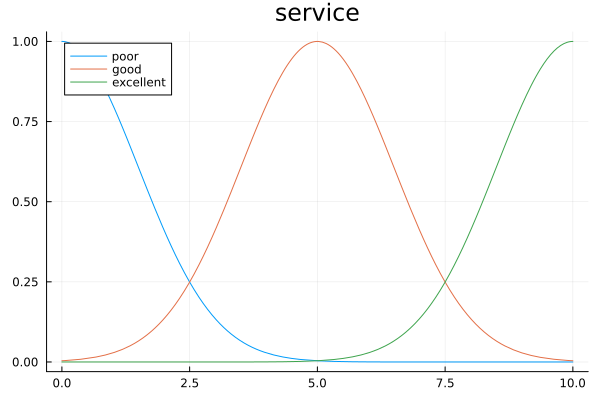

In [4]:
plot(fis, :service)

Giving only the inference system object to `plot` will plot the inference rules, one per line.

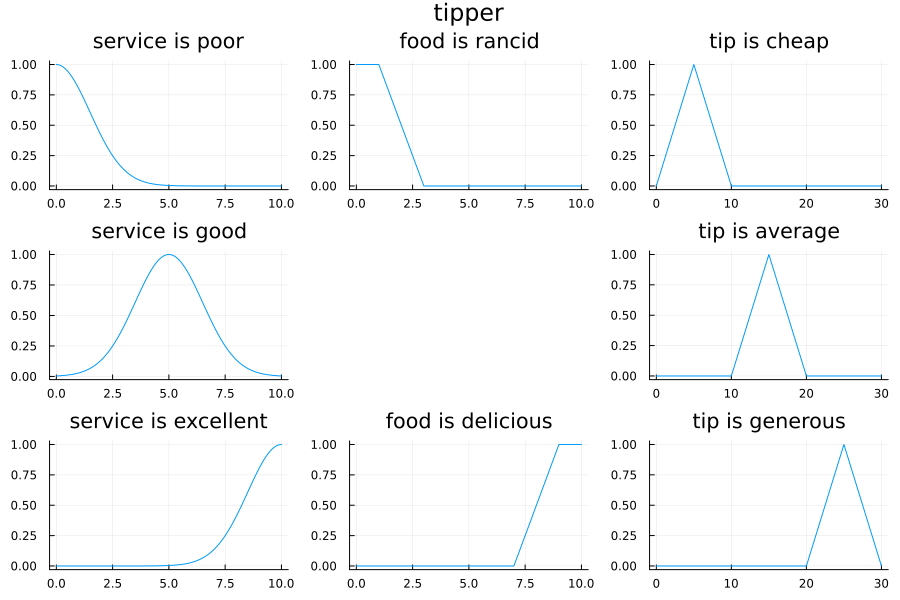

In [5]:
plot(fis)

If the FIS has at most 2 inputs, we can plot the generating surface of the system using the function `gensurf`.
This is a surface visualizing how the output changes as a function of the input.

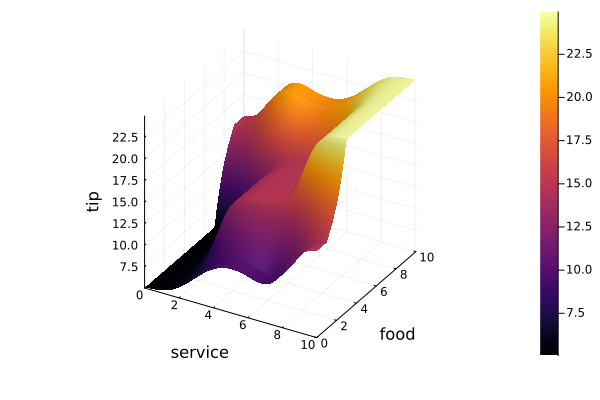

In [6]:
gensurf(fis)

## Inference

To perform inference, you can call the above constructed inference system as a function, passing th input values as parameters.
Note that the system does not accept positional arguments, but inputs should be passed as name-value pairs.
For example

In [7]:
res = fis(service = 2, food = 3)

1-element Dictionaries.Dictionary{Symbol, Float64}
 :tip │ 7.480430420665251

The result is a Dictionary containing the output value corresponding to each output variable.
The value of a specific output variable can be extracted using the variable name as key.

In [8]:
res[:tip]

7.480430420665251

## Code generation

The model can be compiled to native Julia code using the `compilefis` function.
This produces optimized Julia code independent of the library, that can be executed as
stand-alone function.

In [9]:
fis_ex = compilefis(fis)

:(function tipper(service, food)
      poor = exp(-((service - 0.0) ^ 2) / 4.5)
      good = exp(-((service - 5.0) ^ 2) / 4.5)
      excellent = exp(-((service - 10.0) ^ 2) / 4.5)
      rancid = max(min((food - -2) / 2, 1, (3 - food) / 2), 0)
      delicious = max(min((food - 7) / 2, 1, (12 - food) / 2), 0)
      ant1 = (poor + rancid) - poor * rancid
      ant2 = good
      ant3 = (excellent + delicious) - excellent * delicious
      tip_agg = collect(LinRange{Float64}(0.0, 30.0, 101))
      @inbounds for (i, x) = enumerate(tip_agg)
              cheap = max(min((x - 0) / 5, (10 - x) / 5), 0)
              average = max(min((x - 10) / 5, (20 - x) / 5), 0)
              generous = max(min((x - 20) / 5, (30 - x) / 5), 0)
              tip_agg[i] = (((ant1 * cheap + ant2 * average) - (ant1 * cheap) * (ant2 * average)) + ant3 * generous) - ((ant1 * cheap + ant2 * average) - (ant1 * cheap) * (ant2 * average)) * (ant3 * generous)
          end
      tip = ((2 * sum((mfi * xi for (mfi, xi) =

The new expression can now be evaluated as normal Julia code. Notice that the generated
function uses positional arguments.

In [10]:
eval(fis_ex)
tipper(2, 3)

7.480430420665253